I was really excited when I found this dataset. I haven't been to law school myself, but over the years I have tutored a lot of students on the LSAT and have a pretty fair idea of what the process of becoming a lawyer is like. It was fun to work on a dataset where I had some knowledge of the domain.

It wasn't immeditely clear what a lot of the column names on this dataset meant, so I spent a lot of time in data analysis not only getting rid of colinearities and filling in missing data, but trying to figure out what the data in different columns actually represents. 

Just a couple of thoughts about this project. It was a relatively simple dataset. There weren't any large values that needed to be normalized and none of the columns were skewed such that they needed to be log transformed. Other than figuring out which variables to keep and filling in missing values there wasn't a lot to do in data preprocessing.

This is the first project I've completed and a lot of the code for grid search is adapted from Samuel Corintha's __"Spaceship Titanic: A Complete Guide"__ with the help of Github Copilot. It's a similar binary classification problem.

A lot of the analysis I've done here is a best guess and a lot of the code is kludge. Any comments or suggestions about places you think I've made mistakes or could make my code more pythonic are welcome.

I really enjoyed working on this. I'm curious to hear what you guys think. Thank you to Dan Ofer for posting a great dataset.

Best,

Eric

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/law-school-admissions-bar-passage/bar_pass_prediction.csv


# Libraries

In [2]:

# Core
import category_encoders as ce
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import lightgbm as lgb
import time
import plotly.express as px
import warnings
import itertools
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='darkgrid', font_scale=1.4)
warnings.filterwarnings('ignore')
# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

import nbformat

import warnings
warnings.filterwarnings('ignore')



# Dataset

In [3]:
df = pd.read_csv('../input/law-school-admissions-bar-passage/bar_pass_prediction.csv')


In [4]:
df.shape

(22407, 39)

In [5]:
df.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

In [6]:
df.head()

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5


### Duplicates and Null Values

Let's have a quick look at the data for duplicated rows and how many null values each column has.

In [7]:
idsUnique = df['ID'].nunique()
idsTotal = df.shape[0]
idd = idsTotal - idsUnique

print('Number of duplicate IDs:', idd)

Number of duplicate IDs: 0


Great news. It doesn't look like any of our rows duplicate one another. One less thing to worry about.

In [8]:
df.isnull().sum()

decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr                      40
fulltime                     34
fam_inc                     289
age                          89
gender                        5
parttime                     34
male                          5
race1                        16
race2                        16
Dropout                       0
other                         0
asian                         0
black                         0
hisp                          0
pass_bar                      0
bar     

It looks like there are a fair number of null values.

# Identifying Column Names

This dataset didn't include descriptions for most of the columns, so I had a look at the data to try to figure out what each of them represent and to see if any of them are duplicating information.

Dan Ofer was kind enough to post descriptions of some of the important variables, so let's look at those first. They are:

- dnn_bar_pass_prediction: The LSAT prediction from the DNN model. 

- gender: Gender of the student.

- lsat: LSAT score received by the student.

- race: Race of the student.

- ugpa: A student's undergraduate GPA.

- pass_bar: - Ground truth label indicating whether or not the student eventually passed a bar.

- bar_passed - I added a boolean target column for convenience, of whether someone passed the bar at any point

Also, while I'm doing this I'm going to evaluate whether some of these columns are worth keeping fill any na values.

### pass_bar and bar

The columns will represent the target variable of 

In [9]:
df['bar'].nunique()

4

In [10]:
df['bar'].unique()

array(['a Passed 1st time', 'c Failed', 'b Passed 2nd time', 'e non-Grad'],
      dtype=object)

Great news. It doesn't look like any of our rows duplicate one another. One less thing to worry about.

In [11]:
df.isnull().sum()

decile1b                   1604
decile3                    1604
ID                            0
decile1                    1092
sex                           5
race                         16
cluster                      96
lsat                          0
ugpa                          0
zfygpa                      984
DOB_yr                       50
grad                          3
zgpa                       1289
bar1                          0
bar1_yr                      39
bar2                          0
bar2_yr                      40
fulltime                     34
fam_inc                     289
age                          89
gender                        5
parttime                     34
male                          5
race1                        16
race2                        16
Dropout                       0
other                         0
asian                         0
black                         0
hisp                          0
pass_bar                      0
bar     

Text(0.5, 1.0, 'Pass Bar')

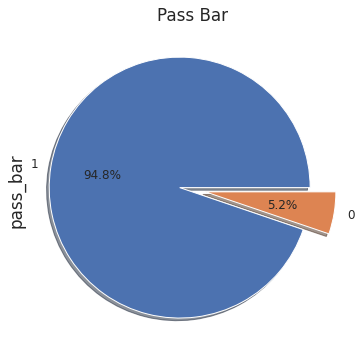

In [12]:
plt.figure(figsize=(6,6))

df['pass_bar'].value_counts().plot.pie(explode = [.1,.1], autopct='%1.1f%%', shadow=True, fontsize=12).set_title('Pass Bar')

### Gender

Seems pretty straightforward. Let's have a look.

In [13]:
def per_passed_graph(df, value):
    df_graph = pd.DataFrame(columns=['value', 'total', 'passed', 'per_passed'])

    for item in df[value].unique():
        try:
            df_graph = df_graph.append({'value': item, 'total': df[df[value] == item].shape[0], 'passed': df[(df[value] == item) & (
                df.pass_bar == 1)].shape[0], 'per_passed': df[(df[value] == item) & (df.pass_bar == 1)].shape[0] / df[df[value] == item].shape[0]}, ignore_index=True)
        except:
            df_graph = df_graph.append({'value': item, 'total': df[df[value] == item].shape[0], 'passed': df[(df[value] == item) & (
                df.pass_bar == 1)].shape[0], 'per_passed': 0}, ignore_index=True)
    sns.catplot(x='value', y='per_passed', data=df_graph, palette='coolwarm', kind = 'bar', height = 8.27, aspect = 11.7/8.27)

In [14]:
df['gender'].value_counts()

male      12576
female     9826
Name: gender, dtype: int64

OK, exactly what I expected.

In [15]:
df['gender'].isnull().sum()

5

OK, there are only 5 missing data points here, so I'm going to replace them with male for simplicity's sake. If anyone can think of a better way to do this, I'm interested to hear their ideas.

In [16]:
df['gender'].fillna('male', inplace=True)

I think numerical data is going to be a little easier to work with here, so I'm going to change these text values to one and zeros.

In [17]:
df['gender'].replace('male', 1, inplace = True)
df['gender'].replace('female', 0, inplace = True)

In [18]:
df['gender'].unique()

array([0, 1])

Looks good.

### LSAT

This column is about a student's LSAT scores. I have a lot of experience teaching standardized tests including the LSAT. Most tests do a pretty bad job measuring student ability, in general and within specific fields. In the economics programs I applied to, using the math section of the GRE to gauge the math one will need in grad school is like seeing how someone will perform in the NFL by having them bounce a tennis ball against a garage door 40 times in a row. 

The LSAT is different. It's an excellent predictor not onlt only of how students will fare in law school, but also how successful they will be as lawyers. This is all to say I think the LSAT will be a good predictor of whether someone passes the bar.

Side note: I think the LSAT would be an __excellent__ dataset for an NLP project to see if an ML algorithm can answer natural language questions that contain formal logic. For example: **"Everyone who studies for Mrs. Apple's math test will get an A. Jane studied for Mrs. Apple's math test. What grade will Jane get on that test?"** As far as I know NLP can't answer questions like that yet. 

In [19]:
df['lsat'].describe()

count    22407.000000
mean        36.767907
std          5.463248
min         11.000000
25%         33.000000
50%         37.000000
75%         41.000000
max         48.000000
Name: lsat, dtype: float64

Interesting. The LSAT scores go from 120 to 180, so this data has been altered in some way.

In [20]:
df['lsat'].head()

0    44.0
1    29.0
2    36.0
3    39.0
4    48.0
Name: lsat, dtype: float64

In [21]:
df.lsat = df.lsat.astype('int')

In [22]:
df['lsat'].describe()

count    22407.000000
mean        36.721426
std          5.501759
min         11.000000
25%         33.000000
50%         37.000000
75%         41.000000
max         48.000000
Name: lsat, dtype: float64

In [23]:
df_lsat = pd.DataFrame(columns = ['score', 'total', 'passed', 'per_passed'])

for score in range(13,49):
    lsat_list = []
    lsat_list.append(int(score))
    lsat_list.append(df[df['lsat'] == score].shape[0])
    lsat_list.append(df[(df['lsat'] == score) & (df['pass_bar'] == 1)].shape[0])
    try:
        lsat_list.append(lsat_list[2]/lsat_list[1])
    except:
        lsat_list.append(0)
    df_lsat = df_lsat.append(pd.Series(lsat_list, index=df_lsat.columns), ignore_index=True)


df_lsat.score = df_lsat.score.astype(int)


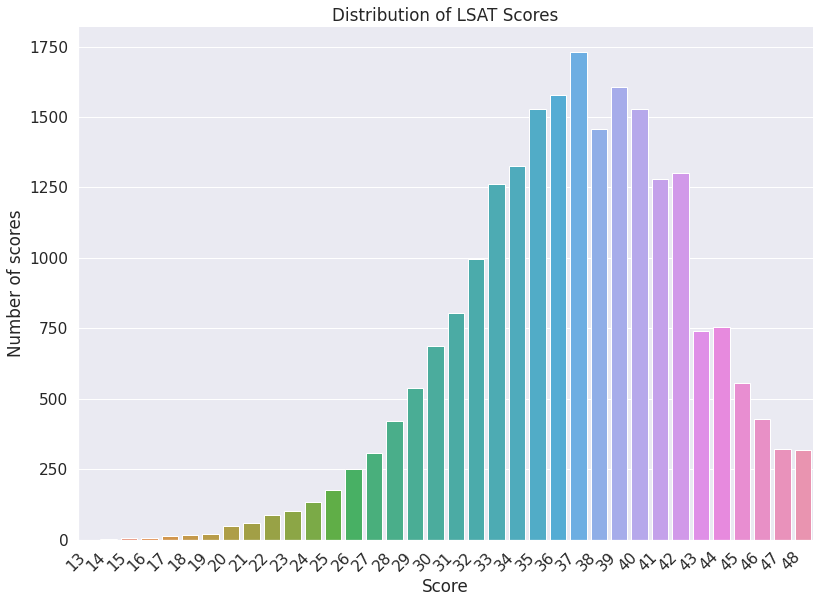

In [24]:
lsat_scores = sns.catplot(x='score', y='total', data=df_lsat,
            kind='bar', height=8.27, aspect=11.7/8.27);

lsat_scores.set(xlabel='Score', ylabel='Number of scores',
                title='Distribution of LSAT Scores');

plt.xticks(rotation = 45, ha = 'right');


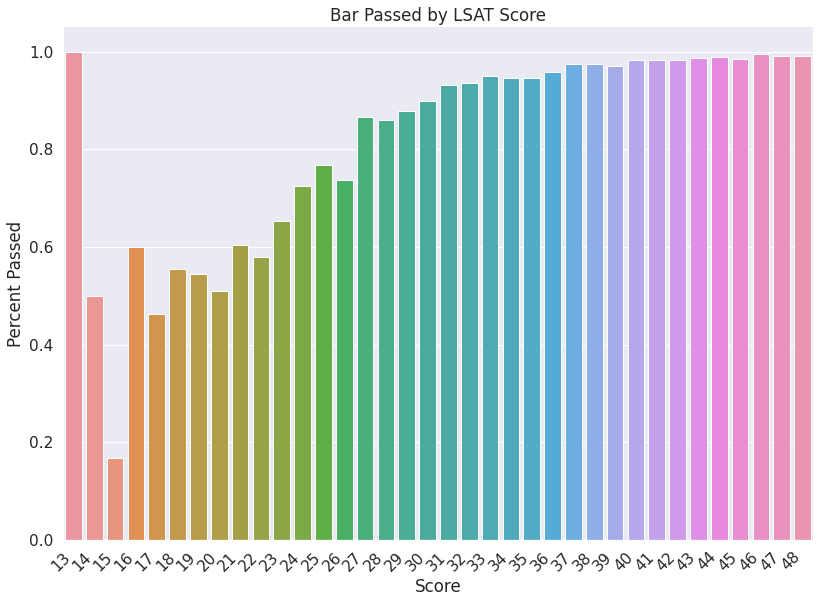

In [25]:
lsat_passed = sns.catplot(x='score', y='per_passed',  data=df_lsat,
            kind='bar', height=8.27, aspect=11.7/8.27);

lsat_passed.set(xlabel='Score', ylabel='Percent Passed',
                title='Bar Passed by LSAT Score');

plt.xticks(rotation = 45, ha = 'right');


As predicted it looks like there is a strong correlation between LSAT score and passing the bar.

### Race

Now let's consider the race variables. There are a bunch of them, so let's see which of them is the most complete and what kind of information they provide.

In [26]:
df_race = df[['race', 'race1','race2', 'other','asian','black','hisp']]
df_race.head()

,race,race1,race2,other,asian,black,hisp
0,7.0,white,b white,0,0,0,0
1,7.0,white,b white,0,0,0,0
2,7.0,white,b white,0,0,0,0
3,7.0,white,b white,0,0,0,0
4,7.0,white,b white,0,0,0,0


In [27]:
df_race.isnull().sum()

race     16
race1    16
race2    16
other     0
asian     0
black     0
hisp      0
dtype: int64

In [28]:
df_race[df_race['race'].isnull() & df_race['race1'].isnull() & df_race['race2'].isnull()].shape[0]

16

OK, surprising. It looks like the missing data in race, race1 and race2 the exact same 16 people have missing values which leads me to believe these columns are duplicating one another. Let's see what kind of information they contain.

In [29]:
df_race['race'].unique()

array([ 7.,  4.,  2.,  3.,  6., nan,  8.,  1.,  5.])

In [30]:
df_race['race1'].unique()

array(['white', 'hisp', 'asian', 'black', nan, 'other'], dtype=object)

In [31]:
df_race['race2'].unique()

array(['b white', 'c other', 'a black', nan], dtype=object)

It looks like race is numerical and race1 and race2 are categorical. I don't know what the numerical data in the race column means, and I'm going to need to one hot encode this information anyway, so I'm going to select race1 and drop the rest. race1 has very few missing values and contains at least as much information as colums asian, black, hisp and other, but I want to see if those columns match what's in race1. 

In [32]:
print('black students in race1: ' + str(df_race[df_race['race1'] == 'black'].shape[0]))
print('black students in column black: ' + str(df_race['black'].sum()))
print('Number of black students in one column and not the other: ' + str(df_race[(df_race['black'] == 1) & (df_race['race1'] != 'black')].shape[0]))

black students in race1: 1343
black students in column black: 1343
Number of black students in one column and not the other: 0


In [33]:
print('hisp students in race1: ' + str(df_race[df_race['race1'] == 'hisp'].shape[0]))
print('hisp students in column hisp: ' + str(df_race['hisp'].sum()))
print('Number of hisp students in one column and not the other: ' + str(df_race[(df_race['hisp'] == 1) & (df_race['race1'] != 'hisp')].shape[0]))

hisp students in race1: 1027
hisp students in column hisp: 105
Number of hisp students in one column and not the other: 105


In [34]:
df_race[df_race['hisp'] == 1]['race1']

529      other
547      other
618      other
889      other
1682     other
         ...  
22253    other
22322    other
22344    other
22384    other
22401    other
Name: race1, Length: 105, dtype: object

In [35]:
df_race[df_race['race1'] == 'hisp']['hisp'].shape

(1027,)

In [36]:
df_race[df_race['hisp'] == 1]['race1'].unique()[0]

'other'

Super interesting. A 1 value in the hisp column does not correspond to hisp in the race1 column. The two columns don't match, but the hisp values aren't random either.

In [37]:
print('asian students in race1: ' + str(df_race[df_race['race1'] == 'asian'].shape[0]))
print('asian students in column asian: ' + str(df_race['asian'].sum()))
print('Number of asian students in one column and not the other: ' + str(df_race[(df_race['asian'] == 1) & (df_race['race1'] != 'asian')].shape[0]))

asian students in race1: 897
asian students in column asian: 897
Number of asian students in one column and not the other: 0


Interesting! The columns for black and asian match perfectly with the categorical data in race1, but the column hisp has __zero__ overlap with 'hisp' in race1. In real life I would want to figure out where this discrepancy came from, but here I'm just going to stick with the data in race1. We should be aware that any analysis we do of the impact of race on bar passage may be compromised by faulty data.

In [38]:
df_race = df['race1'].value_counts()
df_race = df_race.to_frame()
df_race['race'] = ['white', 'black', 'hisp', 'asian','other']
df_race['bar takers'] = 100*df_race['race1']/df.shape[0]
df_race['population'] = [59.3, 12.6, 18.9, 5.9, 3.3 ]
per_pass = []
for i in ['white', 'black', 'hisp', 'asian','other']:
    per_pass.append(100*df[(df['race1'] == i)& (df['pass_bar']==1)].shape[0]/df[df['race1'] == i].shape[0])
    
df_race['percent passed'] =per_pass
df_race.columns

Index(['race1', 'race', 'bar takers', 'population', 'percent passed'], dtype='object')

In [39]:
df_race.head()

,race1,race,bar takers,population,percent passed
white,18716,white,83.527469,59.3,96.639239
black,1343,black,5.993663,12.6,77.810871
hisp,1027,hisp,4.583389,18.9,87.536514
asian,897,asian,4.003213,5.9,92.196210
other,408,other,1.820860,3.3,89.705882


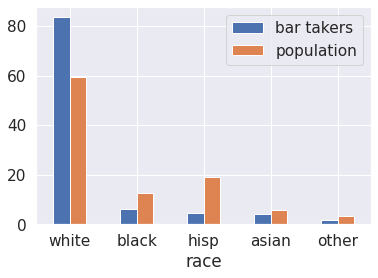

In [40]:
df_race.plot.bar(x = 'race', y = ['bar takers', 'population'], rot = 0);

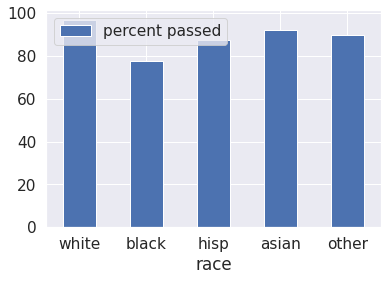

In [41]:
df_race.plot.bar(x = 'race', y = 'percent passed', rot = 0);

It looks like white people are overrepresented in this pool of people taking the bar relative to their portion of the population and every other ethnic group is underrepresented. Also, White people pass the bar at a higher rate than any other racial group.

In [42]:
df['race1'].isnull().sum()

16

There are 16 missing values in race. I feel a little weird doing this, but I'm just going to label them white.

In [43]:
df['race1'].fillna('white', inplace=True)

OK, I'm going to try one hot encoding. race1 is the only categorical variable left, so I think it will be the one one affected.

In [44]:
onehot_encoder = ce.one_hot.OneHotEncoder()
onehot_encoder.fit(df['race1'])
df_ohe = onehot_encoder.transform(df['race1'])


In [45]:
df_ohe.shape

(22407, 5)

In [46]:
df_ohe.head()

,race1_1,race1_2,race1_3,race1_4,race1_5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [47]:
df = df.drop(['race1'], axis=1)

df = pd.concat([df, df_ohe], axis=1)


In [48]:
df = df.drop(['other', 'black', 'hisp','asian', 'race2', 'race'], axis = 1)

### GPA

There are multiple variables with the letters 'gpa' in them. Let's check if they represent different GPAs, possibly from college and law school, or if they convey the same information.


In [49]:
df_gpa = df[['ugpa', 'gpa', 'zgpa', 'zfygpa','pass_bar']]

In [50]:
df_gpa.describe()

,ugpa,gpa,zgpa,zfygpa,pass_bar
count,22407.000000,22407.000000,21118.000000,21423.000000,22407.000000
mean,3.215451,3.215451,0.008756,0.086068,0.947829
std,0.404073,0.404073,0.980993,0.928683,0.222377
min,1.500000,1.500000,-6.440000,-3.350000,0.000000
25%,3.000000,3.000000,-0.680000,-0.560000,1.000000
50%,3.200000,3.200000,0.000000,0.080000,1.000000
75%,3.500000,3.500000,0.680000,0.740000,1.000000
max,3.900000,3.900000,3.450000,3.250000,1.000000


ugpa and gpa look suspiciously similar, but zgpa and zfygpa look odd. I'm wondering if they are z scaled normalizations of the gpa or ugpa columns. Let's check correlations and if ugpa and gpa are a similar as they seem first.

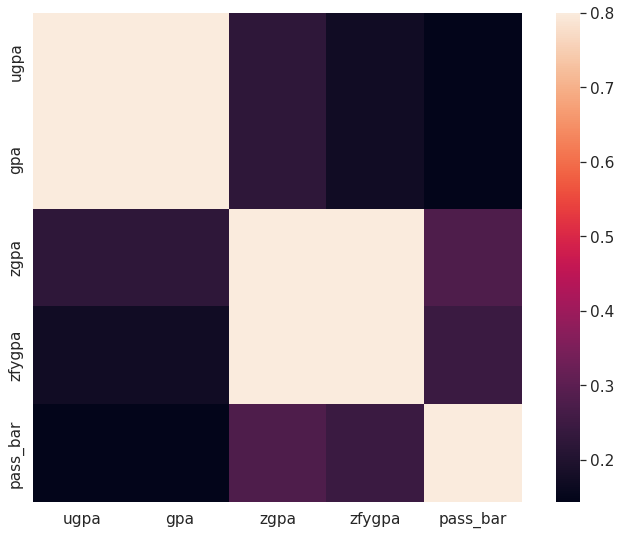

In [51]:
corrmat = df_gpa.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

zgpa and zfygpa aren't transformations of gpa and ugpa. It looks like there is some correlation between all 4 columns, but ugpa and gpa seem to be in one highly correlated group and zgpa and zfygpa are in another.

In [52]:
df_gpa.isnull().sum()

ugpa           0
gpa            0
zgpa        1289
zfygpa       984
pass_bar       0
dtype: int64

In [53]:
corrmat

,ugpa,gpa,zgpa,zfygpa,pass_bar
ugpa,1.000000,1.000000,0.224647,0.173866,0.143276
gpa,1.000000,1.000000,0.224647,0.173866,0.143276
zgpa,0.224647,0.224647,1.000000,0.871557,0.278805
zfygpa,0.173866,0.173866,0.871557,1.000000,0.243983
pass_bar,0.143276,0.143276,0.278805,0.243983,1.000000


In [54]:
df[df['ugpa'] != df['gpa']].shape[0]

0

ugpa and gpa are identical and neither have missing values. Let's drop gpa.

In [55]:
df = df.drop('gpa', axis = 1)

In [56]:
df_gpa = df_gpa.drop('gpa', axis = 1)

Turns out I have no idea what zgpa and zfygpa are, but they do seem to correlate to whether someone passes the bar. We know ugpa is undergraduate GPA from the notes on the dataset, but let's keep looking and try to see if zgpa and zfygpa correspond to anything else.

## Other Variables

Now we take a look at ther variables not labelled by Dan Ofer. Before we go too deep into figuring out what these variables are, let's have a look at which variables correlate to others at greater than 95%.


In [57]:
corrmat = df.corr().abs()

upper = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [58]:
to_drop

['decile1', 'zfygpa', 'zgpa', 'gender', 'parttime', 'male', 'bar_passed']

male and bar_passed are just dupes of pass_bar and gender, and parttime is just the opposite of fulltime, so I'll drop them

In [59]:
df = df.drop(['parttime', 'male', 'bar_passed'], axis = 1)

I want to keep gender, so let's see what's correlating with that.

In [60]:
corrmat['gender'].sort_values(ascending = False)

gender                     1.000000
male                       1.000000
sex                        1.000000
ugpa                       0.135531
dnn_bar_pass_prediction    0.092560
race1_4                    0.091719
lsat                       0.076831
race1_1                    0.074429
decile1                    0.047425
zfygpa                     0.045447
decile1b                   0.044818
fam_inc                    0.043542
cluster                    0.028298
bar2_yr                    0.024244
DOB_yr                     0.023776
race1_3                    0.023694
age                        0.022962
bar_passed                 0.022611
pass_bar                   0.022393
tier                       0.013939
index6040                  0.011403
race1_2                    0.009305
decile3                    0.009070
fulltime                   0.006339
parttime                   0.006339
race1_5                    0.005999
zgpa                       0.004057
bar1_yr                    0

It's sex. Makes sense. I'll drop that.

In [61]:
df = df.drop(['sex'], axis = 1)

Let's see what's correlating with zgpa and zfygpa. That might give us a clue to what those variables are.

In [62]:
corrmat['zgpa'].sort_values(ascending = False)[:5]

zgpa        1.000000
decile3     0.974841
zfygpa      0.871557
decile1b    0.856430
decile1     0.856299
Name: zgpa, dtype: float64

In [63]:
corrmat['zfygpa'].sort_values(ascending = False)[:5]

zfygpa      1.000000
decile1     0.974492
decile1b    0.972201
zgpa        0.871557
decile3     0.852783
Name: zfygpa, dtype: float64

Aha! zgpa corresponds to decile3 and zfygpa corresponds to decile1 and decile1b. Deciles can be a way for law schools to report class rankings, so zgpa and zfygpa are law school gpa. There are multiple deciles, so I'm guessing decile3 is year 3 gpa. Let's look at these variables next.

### Deciles, zgpa and zfygpa

As I mentioned, sometimes law schools rank their students by decile and it looks like the decile columns correlate to the zgpa and zfygpa columns. Let's look deeper.

In [64]:
df_dec = df[['decile1b', 'decile1', 'zfygpa', 'decile3', 'zgpa']]

In [65]:
df_dec.head()

,decile1b,decile1,zfygpa,decile3,zgpa
0,10.0,10.0,1.33,10.0,1.88
1,5.0,5.0,-0.11,4.0,-0.57
2,3.0,3.0,-0.64,2.0,-1.12
3,7.0,7.0,0.34,4.0,-0.49
4,9.0,9.0,1.02,8.0,0.76


In [66]:
df_dec.describe()

,decile1b,decile1,zfygpa,decile3,zgpa
count,20803.000000,21315.000000,21423.000000,20803.000000,21118.000000
mean,5.528481,5.708234,0.086068,5.525934,0.008756
std,2.854800,2.783098,0.928683,2.851286,0.980993
min,1.000000,1.000000,-3.350000,1.000000,-6.440000
25%,3.000000,3.000000,-0.560000,3.000000,-0.680000
50%,6.000000,6.000000,0.080000,6.000000,0.000000
75%,8.000000,8.000000,0.740000,8.000000,0.680000
max,10.000000,10.000000,3.250000,10.000000,3.450000


The decile variables look exactly like we would expect them to if they were law school ranking. The means are a little higher than 5 I'm guessing because people who score at the bottom of their law school classes are more likely to drop out and/or not take the bar.

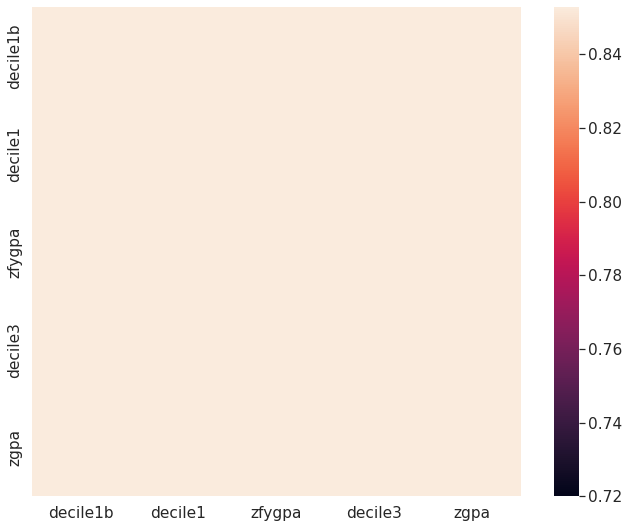

In [67]:
corrmat = df_dec.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Lol! Ok, it looks like there is a fair chance these variables correlate. Let me rescale the correlation matrix and see if we can get a clearer picture of what goes with what.

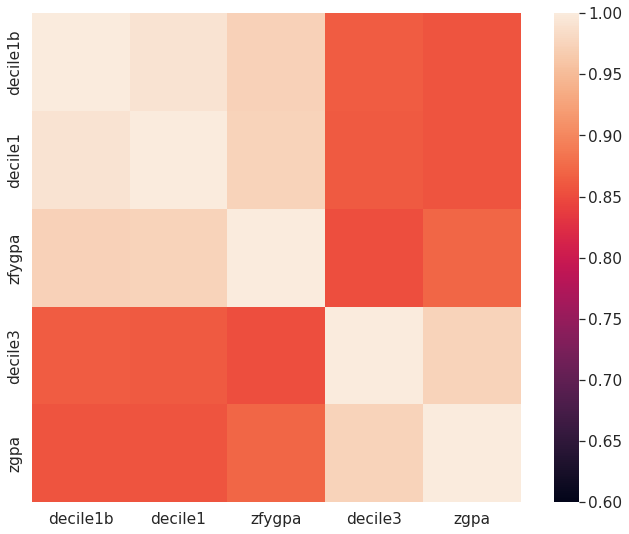

In [68]:
corrmat = df_dec.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, vmin=.6, square=True);

It looks like decile1, decile1b and zfygpa correlate very strongly and so do decile3 and zgpa. Let's see exactly what those numbers are.

In [69]:
corrmat['decile1'].sort_values(ascending = False)

decile1     1.000000
decile1b    0.990840
zfygpa      0.974492
decile3     0.862383
zgpa        0.856299
Name: decile1, dtype: float64

In [70]:
corrmat['decile3'].sort_values(ascending = False)

decile3     1.000000
zgpa        0.974841
decile1b    0.864000
decile1     0.862383
zfygpa      0.852783
Name: decile3, dtype: float64

In [71]:
df_dec.isnull().sum()

decile1b    1604
decile1     1092
zfygpa       984
decile3     1604
zgpa        1289
dtype: int64

It looks like were getting above 95% correlation within these groups. The data in the decile columns seems more intuitive to me, so I'm just going to keep deciles 1 and 3. 

Looking at the isnull data we see a fair amount of missing values in these columns, so maybe I'll be able to fill in some missing values in decile 3 and 1 from the data in decile1b, zgpa and zfygpa.

In [72]:
df[df['decile1'].isnull()&~df['decile1b'].isnull()].shape[0]

0

It looks like there are no values missing in decile1 that are present in decile1b, so I'm dropping decile1b.

In [73]:
df = df.drop('decile1b', axis=1)

In [74]:
df[df['decile1'].isnull()&~df['zfygpa'].isnull()].shape[0]

108

In [75]:
df[~df['decile1'].isnull()&df['zfygpa'].isnull()].shape[0]

0

There are 108 values present in zfygpa that are missing from decile1 and no values in decile1 that are missing in zfygpa

In [76]:
df_zfy = df[['zfygpa', 'decile1']]

df_zfy.head()

,zfygpa,decile1
0,1.33,10.0
1,-0.11,5.0
2,-0.64,3.0
3,0.34,7.0
4,1.02,9.0


In [77]:
df_zfy[df['decile1'].isnull() & ~df['zfygpa'].isnull()].head()

,zfygpa,decile1
184,0.72,NaN
377,0.20,NaN
1216,0.80,NaN
1292,0.84,NaN
1392,0.90,NaN


I feel more comfortable with the decile variables, so I'm going to keep them. What I'm doing next is fill in the missing decile values with information from the zfygpa column. I'll do that by creating a list of the minimum zfygpa values that scored in a certain decile and then filling the missing values with the decile score that scored above that minima.  

In [78]:
condlist = []

for i in range(1,11):
    condlist.append(df_zfy[df_zfy['decile1'] == i]['zfygpa'].min())
    
   

In [79]:
condlist

[-3.35, -1.3, -0.89, -0.58, -0.3, -0.02, 0.2, 0.51, 0.81, 1.23]

In [80]:
df['decile1'] = df.apply(lambda row: 9 if np.isnan(row['decile1']) & (row['zfygpa'] > .81) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 8 if np.isnan(row['decile1']) & (row['zfygpa'] > .51) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 7 if np.isnan(row['decile1']) & (row['zfygpa'] > .2) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 6 if np.isnan(row['decile1']) & (row['zfygpa'] > -.02) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 5 if np.isnan(row['decile1']) & (row['zfygpa'] > -.3) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 4 if np.isnan(row['decile1']) & (row['zfygpa'] > -.58) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 3 if np.isnan(row['decile1']) & (row['zfygpa'] > -.89) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 2 if np.isnan(row['decile1']) & (row['zfygpa'] > -1.3) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 1 if np.isnan(row['decile1']) & (row['zfygpa'] > -3.35) else row['decile1'], axis = 1)

I'm pretty sure that was the worst possible way to do conditional replacement in a dataframe. If anyone can suggest a better one, I would love to hear it!

In [81]:
df[df['decile3'].isnull()& ~df['zgpa'].isnull()].shape[0]

315

There are 315 values missing from decile3 that are present in zgpa. There are no values in zgpa missing from decile3. 

In [82]:
df_z = df[['zgpa', 'decile3']]

df_z.head()

,zgpa,decile3
0,1.88,10.0
1,-0.57,4.0
2,-1.12,2.0
3,-0.49,4.0
4,0.76,8.0


In [83]:
df_z[df['decile3'].isnull() & ~df['zgpa'].isnull()].head()

,zgpa,decile3
184,0.95,NaN
223,0.20,NaN
377,-0.55,NaN
529,-0.42,NaN
688,0.64,NaN


I'm doing the same thing here with decile3 and zgpa.

In [84]:
condlist = []

for i in range(1,11):
    condlist.append(df_z[df_z['decile3'] == i]['zgpa'].min())
 

In [85]:
condlist

[-6.44, -1.34, -0.91, -0.6, -0.33, -0.05, 0.21, 0.5, 0.83, 1.24]

In [86]:
df['decile3'] = df.apply(lambda row: 10 if np.isnan(row['decile3']) & (row['zgpa'] > 1.24) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 9 if np.isnan(row['decile3']) & (row['zgpa'] > .83) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 8 if np.isnan(row['decile3']) & (row['zgpa'] > .5) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 7 if np.isnan(row['decile3']) & (row['zgpa'] > .21) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 6 if np.isnan(row['decile3']) & (row['zgpa'] > -.05) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 5 if np.isnan(row['decile3']) & (row['zgpa'] > -.33) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 4 if np.isnan(row['decile3']) & (row['zgpa'] > -.6) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 3 if np.isnan(row['decile3']) & (row['zgpa'] > -.91) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 2 if np.isnan(row['decile3']) & (row['zgpa'] > -1.34) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 1 if np.isnan(row['decile3']) & (row['zgpa'] > -6.44) else row['decile3'], axis = 1)

In [87]:
df_z[df['decile3'].isnull() & ~df['zgpa'].isnull()].shape[0]

0

In [88]:
df_z.isnull().sum()

zgpa       1289
decile3    1604
dtype: int64

In [89]:
df = df.drop(['zfygpa', 'zgpa'], axis = 1)

Awesome! We figured out what the zfygpa, zgpa, and decile variables are and were able to fill in some missing values in one column with information from another.

In [90]:
df.columns

Index(['decile3', 'ID', 'decile1', 'cluster', 'lsat', 'ugpa', 'DOB_yr', 'grad',
       'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age',
       'gender', 'Dropout', 'pass_bar', 'bar', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'race1_1', 'race1_2', 'race1_3',
       'race1_4', 'race1_5'],
      dtype='object')

Now on to the column names that aren't labelled and don't correlate with another column.

### DOB_yr and age

These variables seem like clear duplicates, so let's have a look at them.

In [91]:
df_age = df[['DOB_yr', 'age']]

In [92]:
df_age.head()

,DOB_yr,age
0,69.0,-62.0
1,69.0,-62.0
2,65.0,-58.0
3,58.0,-51.0
4,68.0,-61.0


In [93]:
df_age.describe()

,DOB_yr,age
count,22357.000000,22318.000000
mean,65.440712,-59.082893
std,5.207162,5.311722
min,10.000000,-69.000000
25%,64.000000,-62.000000
50%,67.000000,-61.000000
75%,69.000000,-58.000000
max,71.000000,-3.000000


This is... not what I was expecting. Neither variable makes much sense. I'm going to check if either variable correlates with pass_bar and if they don't I'm just going to drop them.

In [94]:
df_age.isnull().sum()

DOB_yr    50
age       89
dtype: int64

In [95]:
df_age = df[['DOB_yr', 'age', 'pass_bar']]

<AxesSubplot:>

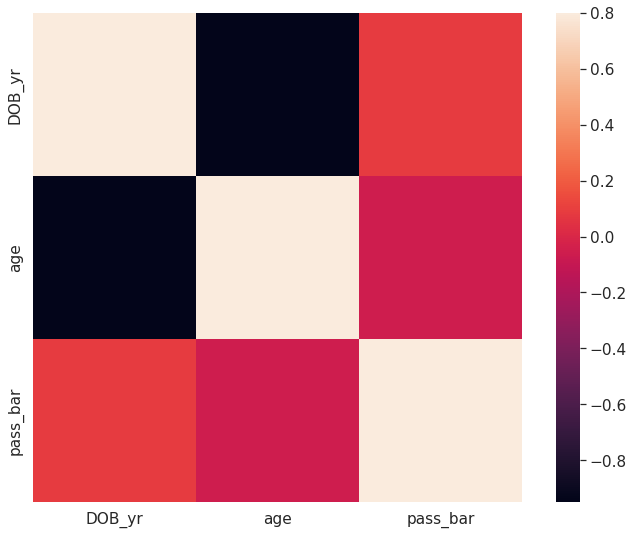

In [96]:
corrmat = df_age.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [97]:
corrmat['pass_bar']

DOB_yr      0.084911
age        -0.059644
pass_bar    1.000000
Name: pass_bar, dtype: float64

They both seem to have really low correlations, so I'm going to drop them.

In [98]:
df = df.drop(['DOB_yr','age'], axis = 1)

### ID

My guess is this is just an index column. Let's see.

In [99]:
df['ID'].describe()

count    22407.000000
mean     13768.253537
std       7929.063192
min          2.000000
25%       6926.500000
50%      13772.000000
75%      20628.500000
max      27477.000000
Name: ID, dtype: float64

In [100]:
df[df['ID'].duplicated()]

,decile3,ID,decile1,cluster,lsat,ugpa,grad,bar1,bar1_yr,bar2,...,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,race1_1,race1_2,race1_3,race1_4,race1_5


It looks like it's just an ID number. No duplicates. I'm going to drop it.

In [101]:
df = df.drop('ID', axis =1)

In [102]:
df.columns

Index(['decile3', 'decile1', 'cluster', 'lsat', 'ugpa', 'grad', 'bar1',
       'bar1_yr', 'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'gender',
       'Dropout', 'pass_bar', 'bar', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'race1_1', 'race1_2', 'race1_3',
       'race1_4', 'race1_5'],
      dtype='object')

### cluster

I have no idea what this could be, but let's take a look at it.

In [103]:
df['cluster'].describe()

count    22311.000000
mean         2.817355
std          1.384079
min          1.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: cluster, dtype: float64

<AxesSubplot:>

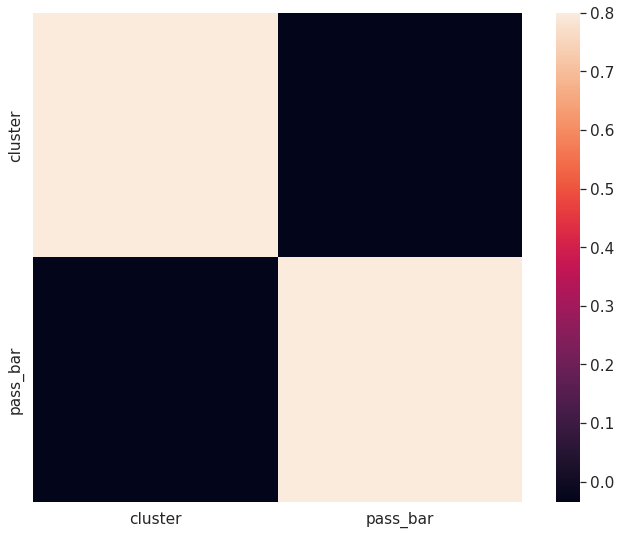

In [104]:
corrmat = df[['cluster','pass_bar']].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

I don't know what it is and it has no correlation with pass_bar, so I'm dropping it.

In [105]:
df = df.drop('cluster', axis =1)

In [106]:
df.columns

Index(['decile3', 'decile1', 'lsat', 'ugpa', 'grad', 'bar1', 'bar1_yr', 'bar2',
       'bar2_yr', 'fulltime', 'fam_inc', 'gender', 'Dropout', 'pass_bar',
       'bar', 'tier', 'index6040', 'indxgrp', 'indxgrp2',
       'dnn_bar_pass_prediction', 'race1_1', 'race1_2', 'race1_3', 'race1_4',
       'race1_5'],
      dtype='object')

### bar1, bar1_yr, bar2, bar2_yr and bar

These variables either duplicate pass_bar or give info on when a student passed the bar, so they wouldn't have predictive value. I'm dropping them.

In [107]:
df = df.drop(['bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'bar'], axis = 1)

In [108]:
df.columns

Index(['decile3', 'decile1', 'lsat', 'ugpa', 'grad', 'fulltime', 'fam_inc',
       'gender', 'Dropout', 'pass_bar', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'race1_1', 'race1_2', 'race1_3',
       'race1_4', 'race1_5'],
      dtype='object')

### index6040, indxgrp, indxgrp2

No clue what these could be. Let's see if the correlate with pass_bar

In [109]:
df_idx = df[['index6040', 'indxgrp', 'indxgrp2','pass_bar']]
df_idx.describe()

,index6040,pass_bar
count,22407.000000,22407.000000
mean,744.196203,0.947829
std,103.770570,0.222377
min,288.947365,0.000000
25%,678.947352,1.000000
50%,747.894717,1.000000
75%,815.263136,1.000000
max,989.999974,1.000000


In [110]:
df_idx.head()

,index6040,indxgrp,indxgrp2,pass_bar
0,886.842082,g 700+,i 820+,1
1,649.999987,f 640-700,f 640-700,1
2,760.526298,g 700+,h 760-820,1
3,807.894717,g 700+,h 760-820,1
4,949.999974,g 700+,i 820+,1


<AxesSubplot:>

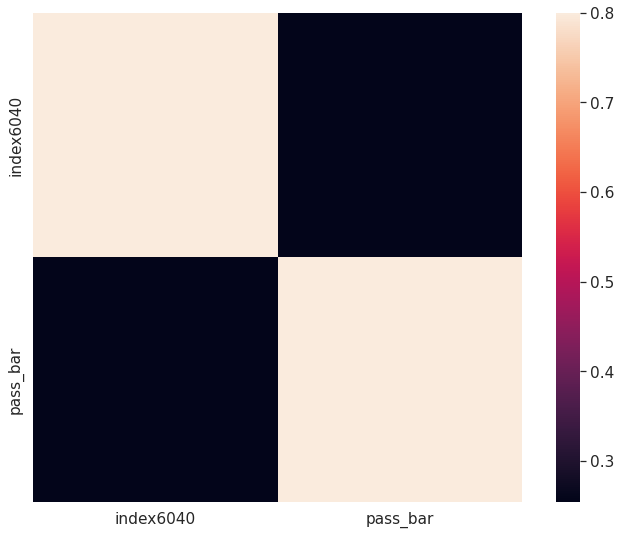

In [111]:
corrmat = df_idx.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

index6040 has no correlation with passing the bar, so I'm dropping it.

In [112]:
df['indxgrp'].unique()


array(['g 700+', 'f 640-700', 'e 580-640', 'd 520-580', 'c 460-520',
       'b 400-460', 'a under 400'], dtype=object)

In [113]:
values = ['g 700+', 'f 640-700', 'e 580-640', 'd 520-580', 'c 460-520',
          'b 400-460', 'a under 400']
counts = []

for i in values:
    counts.append((df[df['indxgrp'] == i]['pass_bar'].sum())/df[df['indxgrp'] == i].shape[0])

df_idxcount = pd.DataFrame({'indxgrp': values, 'pass_bar': counts})
df_idxcount

,indxgrp,pass_bar
0,g 700+,0.977344
1,f 640-700,0.939963
2,e 580-640,0.889744
3,d 520-580,0.799759
4,c 460-520,0.690418
5,b 400-460,0.511628
6,a under 400,0.333333


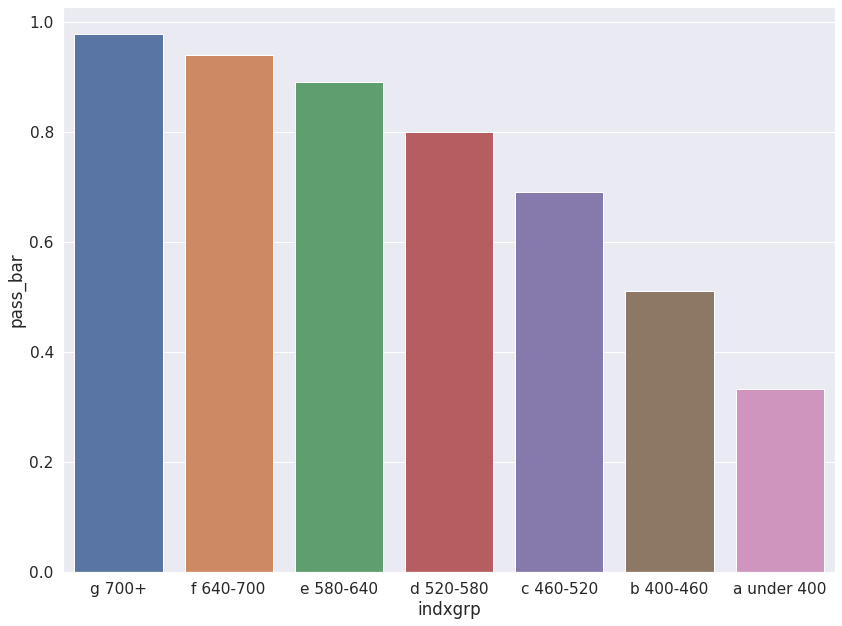

In [114]:
fig = plt.figure(figsize=(12, 9))
sns.barplot(x='indxgrp', y='pass_bar', data=df_idxcount)
fig.tight_layout()
plt.show()


It looks like indxgrp has a strong correlation to pass_bar. My concern is that not knowing what indxgrp means we can't tell whether it represents information available before or after someone took the bar. I'm going to leave it in and replace the strings with integers.

In [115]:
df['indxgrp'].replace({'g 700+': 7, 'f 640-700': 6, 'e 580-640': 5, 'd 520-580': 4, 'c 460-520': 3, 'b 400-460': 2, 'a under 400': 1}, inplace=True)

In [116]:
df['indxgrp2'].unique()


array(['i 820+', 'f 640-700', 'h 760-820', 'g 700-760', 'e 580-640',
       'd 520-580', 'c 460-520', 'b 400-460', 'a under 400'], dtype=object)

In [117]:
values = ['i 820+', 'f 640-700', 'h 760-820', 'g 700-760', 'e 580-640',
          'd 520-580', 'c 460-520', 'b 400-460', 'a under 400']
counts = []

for i in values:
    counts.append((df[df['indxgrp2'] == i]['pass_bar'].sum()) /
                  df[df['indxgrp2'] == i].shape[0])

df_idx2count = pd.DataFrame({'indxgrp2': values, 'pass_bar': counts})
df_idx2count


,indxgrp2,pass_bar
0,i 820+,0.990651
1,f 640-700,0.939963
2,h 760-820,0.979192
3,g 700-760,0.961981
4,e 580-640,0.889744
5,d 520-580,0.799759
6,c 460-520,0.690418
7,b 400-460,0.511628
8,a under 400,0.333333


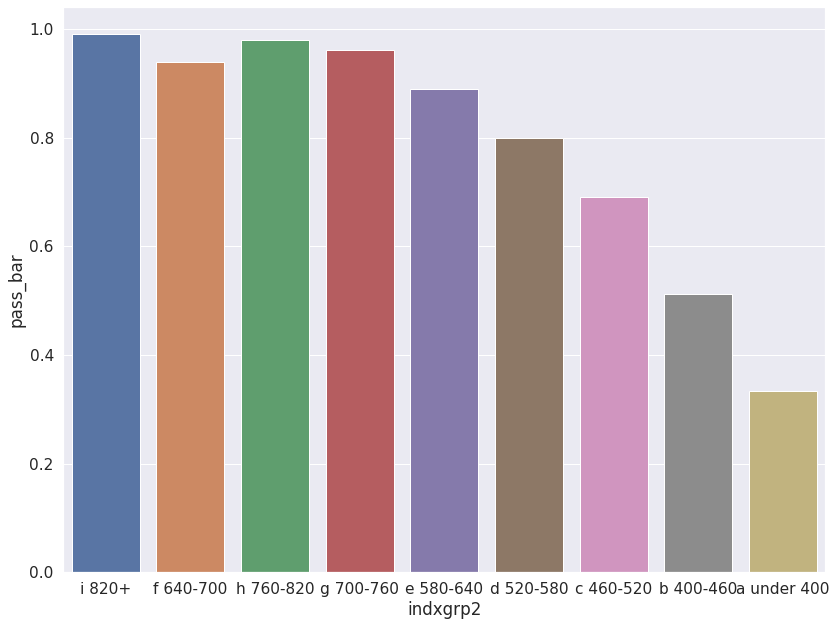

In [118]:
fig = plt.figure(figsize=(12, 9))
sns.barplot(x='indxgrp2', y='pass_bar', data=df_idx2count)
fig.tight_layout()
plt.show()


In [119]:
df['indxgrp2'].replace({'i 820+': 9, 'f 640-700': 6, 'h 760-820': 8, 'g 700-760': 7, 'e 580-640': 5, 'd 520-580': 4, 'c 460-520': 3, 'b 400-460': 2, 'a under 400': 1}, inplace=True)


In [120]:
df[['indxgrp', 'indxgrp2']].describe()

,indxgrp,indxgrp2
count,22407.000000,22407.000000
mean,6.434329,7.120900
std,1.013457,1.576991
min,1.000000,1.000000
25%,6.000000,6.000000
50%,7.000000,7.000000
75%,7.000000,8.000000
max,7.000000,9.000000


In [121]:
df = df.drop(['index6040'], axis = 1)

### tier

What the heck is tier? My guess: what tier law school the student went to. Proably pretty important.

In [122]:
df['tier'].unique()

array([ 4.,  2.,  3.,  5.,  1.,  6., nan])

In [123]:
df['tier'].isnull().sum()

96

In [124]:
df['tier'].value_counts()

3.0    7991
4.0    6083
5.0    3895
6.0    2054
2.0    1694
1.0     594
Name: tier, dtype: int64

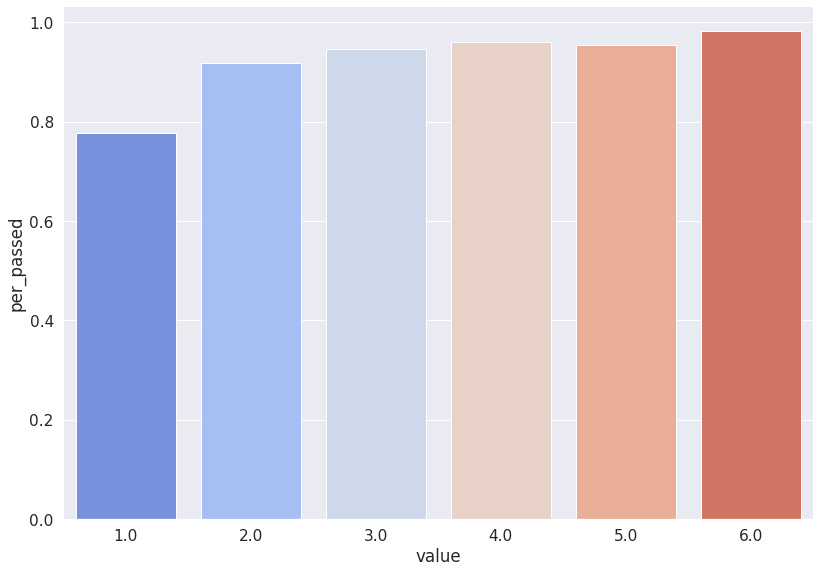

In [125]:
per_passed_graph(df, 'tier')

Yeah, it seems like tier 6 represents selective schools while tier 1 represents non-selective schools. This variable is a definite keeper. I'm going to fill the nas with 3.



In [126]:
df['tier'].fillna(3.0, inplace=True)

### fam_inc

I'm going to check this variable against the percentage of people who passed the bar to see if I should keep it.

In [127]:
df['fam_inc'].value_counts()

4.0    9771
3.0    7896
2.0    2183
5.0    1814
1.0     454
Name: fam_inc, dtype: int64

It looks like fam_inc which I assume stands for family income is broken up into quintiles. Now I'm going to graph those quintiles against number of responses per quintile and percent admited per quintile.

In [128]:

df_fam_inc = pd.DataFrame(columns=['score', 'total', 'passed', 'per_passed'])

In [129]:

for score in range(1,6):
    score = float(score)
    fam_inc_list = []
    fam_inc_list.append(score)
    fam_inc_list.append(df[df['fam_inc'] == score].shape[0])
    fam_inc_list.append(
        df[(df['fam_inc'] == score) & (df['pass_bar'] == 1)].shape[0])
    try:
        fam_inc_list.append(fam_inc_list[2]/fam_inc_list[1])
    except:
        fam_inc_list.append(0)
    df_fam_inc = df_fam_inc.append(
        pd.Series(fam_inc_list, index=df_fam_inc.columns), ignore_index=True)

In [130]:
df_fam_inc.shape

(5, 4)

In [131]:
df_fam_inc.head()

,score,total,passed,per_passed
0,1.0,454.0,391.0,0.861233
1,2.0,2183.0,1993.0,0.912964
2,3.0,7896.0,7449.0,0.943389
3,4.0,9771.0,9393.0,0.961314
4,5.0,1814.0,1746.0,0.962514


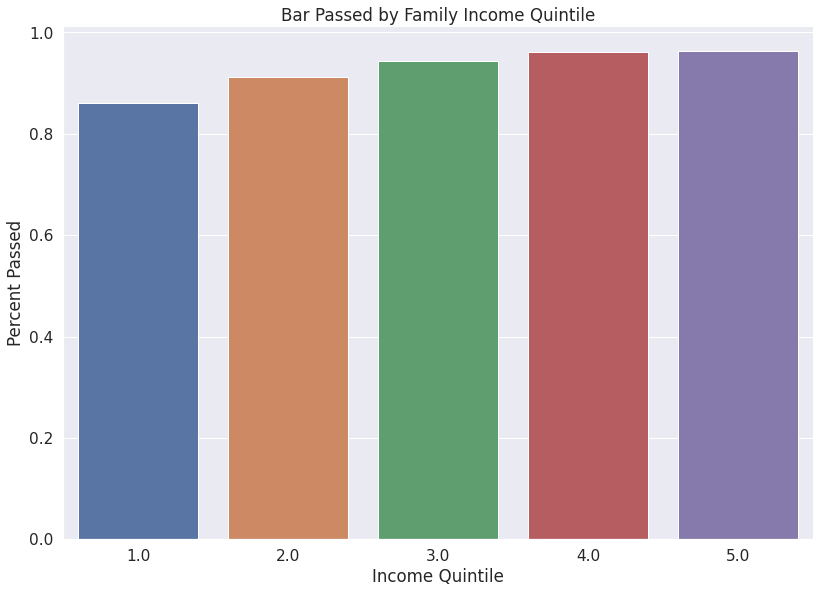

In [132]:
fam_inc = sns.catplot(x='score', y='per_passed', data=df_fam_inc,
            kind='bar', height=8.27, aspect=11.7/8.27);

fam_inc.set(xlabel='Income Quintile', ylabel='Percent Passed',
                title='Bar Passed by Family Income Quintile');


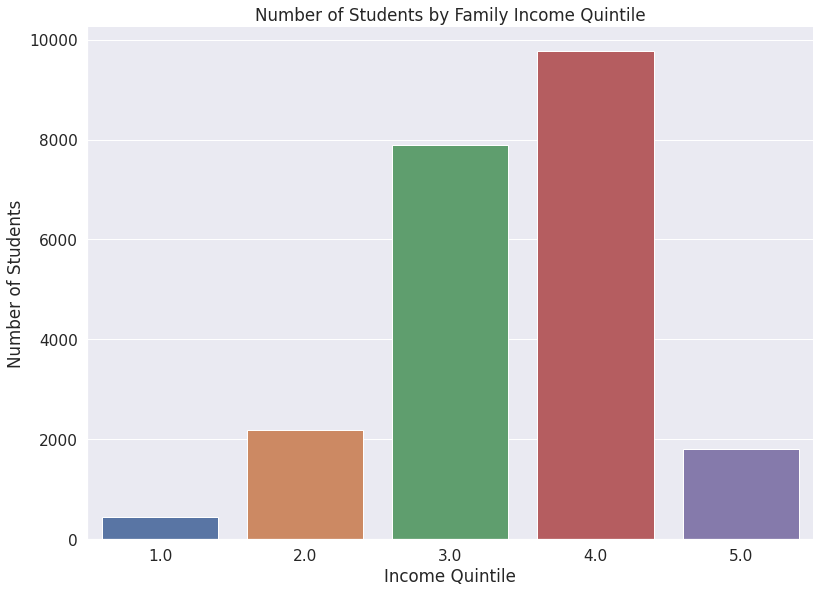

In [133]:
fam_inc_pop = sns.catplot(x='score', y='total', data=df_fam_inc,
            kind='bar', height=8.27, aspect=11.7/8.27);

fam_inc_pop.set(xlabel='Income Quintile', ylabel='Number of Students',
            title='Number of Students by Family Income Quintile');


Interesting! If I'm right and 1-5 represent quintiles then it looks like the number of bar takers from each group increases as people get richer until you get to the richest quintile when it drops way down again. I guys rich kids don't want to go into a field where you have to work yourself to death.

It looks like fam_inc will be a pretty good predictive variable. I'm going to fill the nas with 4s.

In [134]:
df['fam_inc'].fillna(4.0, inplace=True)

### Dropout and grad

Dropout and grad probably indicate the same information: whether someone graduated from or dropped out of law school. I can't imagine there are that many people who dropped out of law school then took the bar, but let's see.

In [135]:
df['Dropout'].unique()

array(['NO', 'YES'], dtype=object)

In [136]:
df['Dropout'].value_counts()

NO     22406
YES        1
Name: Dropout, dtype: int64

In [137]:
df[(df['Dropout'] == 'YES')]

,decile3,decile1,lsat,ugpa,grad,fulltime,fam_inc,gender,Dropout,pass_bar,tier,indxgrp,indxgrp2,dnn_bar_pass_prediction,race1_1,race1_2,race1_3,race1_4,race1_5
7020,NaN,7.0,39,3.2,O,1.0,4.0,0,YES,1,3.0,7,8,0.996526,1,0,0,0,0


I'm guessing this is whether someone dropped out of law school and still passed the bar. The fact that there is exactly on YES value however makes me think this is not going to have real predictive value. 


In [138]:
df['grad'].unique()

array(['Y', 'X', nan, 'O'], dtype=object)

In [139]:
df['grad'].value_counts()

Y    22315
X       88
O        1
Name: grad, dtype: int64

Interesting. I was really expecting a binary variable. It's almost a binary variable though with just one O value out of 20+ thousand. Also, looking above we see that the one person with a YES Dropout value is the one person with an O for grad. I'm wondering if the X value stands for some sort of conditional graduation, like the student had to transfer their credits to a correspondence law school (Go Landcrabs!) to get a degree. I'm just guessing, but that's the best I can come up with.

In [140]:
df[(df['grad'] == 'X')  & df['Dropout'].isnull()].shape[0]

0

I ran the above line of code because I wanted to see if maybe X meant the student dropped out, but the data was recorded in the Dropout column as na. No dice. Let's look further at the grad variable.

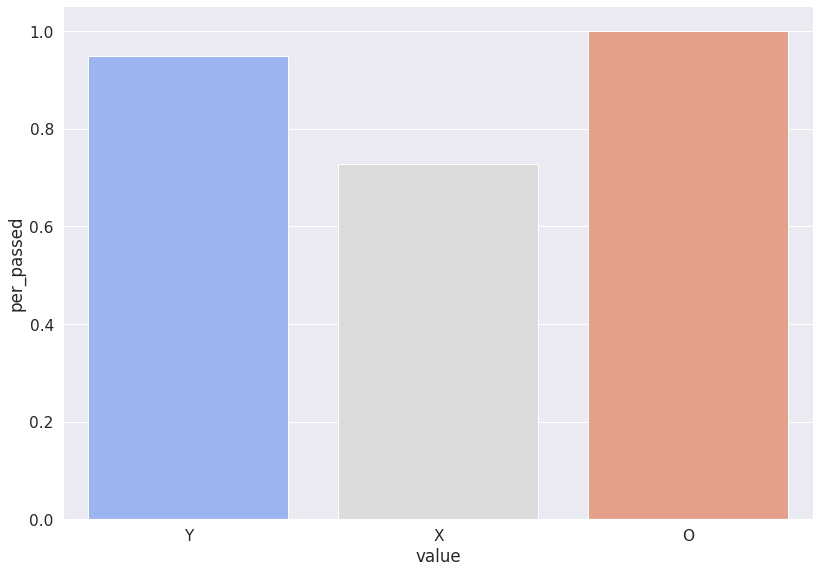

In [141]:
per_passed_graph(df, 'grad')

OK, grad seems like an excellent predictor of whether someone will pass the bar. I'm going to keep it. I'm torn between whether I should lump the 0 value in with X, Y or just drop it. I'm going to keep the outlier and lump it in with X, because, it seems intuitive that someone dropping out of law school would be less likely to pass the bar.

In [142]:
df['grad'] = df['grad'].replace(['Y', 'X','O'],[1,0,0])

In [143]:
df = df.drop('Dropout', axis = 1)

In [144]:
df[df['grad'] == 0].shape

(89, 18)

In [145]:
df['grad'] = df['grad'].fillna(1)

### fulltime

Does this represent student who attend law school full time or students who work full time and attend law school? I think it's the former, but I also think the value counts will tell for sure. Also, if it is the variable for students who attend law school full time I'm curious to see if it correlates to passing the bar.

In [146]:
df['fulltime'].unique()

array([ 1.,  2., nan])

In [147]:

df['fulltime'].value_counts()

1.0    20653
2.0     1720
Name: fulltime, dtype: int64

This suggests to me that fulltime indicates students who attend law school full time.

In [148]:
df['fulltime'].isnull().sum()

34

Filling the nas with 1 feels like a no brainer.

In [149]:
df['fulltime'].fillna(1.0, inplace=True)

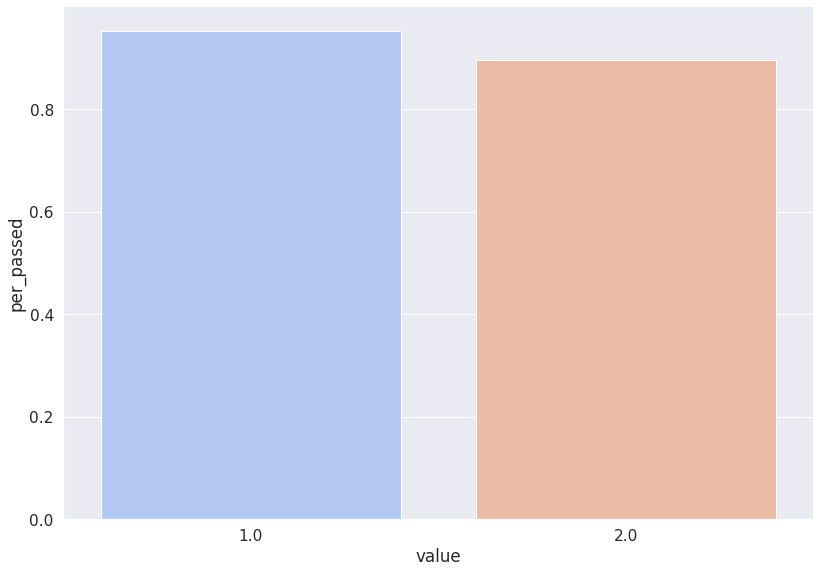

In [150]:
per_passed_graph(df, 'fulltime')

It doesn't seem like there is a strong correlation here, but I'll leave it in. I know it doesn't matter, but I'm not wild about the 1, 2 format of the data, so I'm going to change it so 1, 0.

In [151]:
df['fulltime'] = df['fulltime'].replace(2, 0)

In [152]:
df.columns

Index(['decile3', 'decile1', 'lsat', 'ugpa', 'grad', 'fulltime', 'fam_inc',
       'gender', 'pass_bar', 'tier', 'indxgrp', 'indxgrp2',
       'dnn_bar_pass_prediction', 'race1_1', 'race1_2', 'race1_3', 'race1_4',
       'race1_5'],
      dtype='object')

### dnn_bar_pass_prediction

This is some other algorithm for predicting whether someone will pass the bar. It doesn't feel appropriate to use it in my own prediction, so I'm dropping it.

In [153]:
df = df.drop('dnn_bar_pass_prediction', axis = 1)

# Missing Values

In [154]:
df.isnull().sum()

decile3     1289
decile1      984
lsat           0
ugpa           0
grad           0
fulltime       0
fam_inc        0
gender         0
pass_bar       0
tier           0
indxgrp        0
indxgrp2       0
race1_1        0
race1_2        0
race1_3        0
race1_4        0
race1_5        0
dtype: int64

Up to this point I've been filling in some missing values as I go just because they seem obvious. fulltime got filled in with one because the preponderance of values are one. It was the same thing with fam_inc. decile1 and decile3 seem different. I think the way to fill them in is to predict them the way we would a target variable and us those values to fill the nas. Right now, I'm trying to get this posted, so I'm just going to fill the nas with the column mean. I'll probably update this later.

In [155]:
df['decile3'].fillna(5, inplace = True)

In [156]:
df['decile1'].fillna(5, inplace = True)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22407 entries, 0 to 22406
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   decile3   22407 non-null  float64
 1   decile1   22407 non-null  float64
 2   lsat      22407 non-null  int64  
 3   ugpa      22407 non-null  float64
 4   grad      22407 non-null  float64
 5   fulltime  22407 non-null  float64
 6   fam_inc   22407 non-null  float64
 7   gender    22407 non-null  int64  
 8   pass_bar  22407 non-null  int64  
 9   tier      22407 non-null  float64
 10  indxgrp   22407 non-null  int64  
 11  indxgrp2  22407 non-null  int64  
 12  race1_1   22407 non-null  int64  
 13  race1_2   22407 non-null  int64  
 14  race1_3   22407 non-null  int64  
 15  race1_4   22407 non-null  int64  
 16  race1_5   22407 non-null  int64  
dtypes: float64(7), int64(10)
memory usage: 2.9 MB


In [158]:
df.head()

,decile3,decile1,lsat,ugpa,grad,fulltime,fam_inc,gender,pass_bar,tier,indxgrp,indxgrp2,race1_1,race1_2,race1_3,race1_4,race1_5
0,10.0,10.0,44,3.5,1.0,1.0,5.0,0,1,4.0,7,9,1,0,0,0,0
1,4.0,5.0,29,3.5,1.0,1.0,4.0,0,1,2.0,6,6,1,0,0,0,0
2,2.0,3.0,36,3.5,1.0,1.0,1.0,1,1,3.0,7,8,1,0,0,0,0
3,4.0,7.0,39,3.5,1.0,1.0,4.0,1,1,3.0,7,8,1,0,0,0,0
4,8.0,9.0,48,3.5,1.0,1.0,4.0,1,1,5.0,7,9,1,0,0,0,0


Let's get this data cleaned up a little bit. It looks like except for ugpa we can express all these floats as ints.

In [159]:
df[['decile3', 'decile1','lsat', 'grad', 'fulltime', 'fam_inc', 'tier']] = df[['decile3', 'decile1','lsat', 'grad', 'fulltime', 'fam_inc', 'tier']].astype(int)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22407 entries, 0 to 22406
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   decile3   22407 non-null  int64  
 1   decile1   22407 non-null  int64  
 2   lsat      22407 non-null  int64  
 3   ugpa      22407 non-null  float64
 4   grad      22407 non-null  int64  
 5   fulltime  22407 non-null  int64  
 6   fam_inc   22407 non-null  int64  
 7   gender    22407 non-null  int64  
 8   pass_bar  22407 non-null  int64  
 9   tier      22407 non-null  int64  
 10  indxgrp   22407 non-null  int64  
 11  indxgrp2  22407 non-null  int64  
 12  race1_1   22407 non-null  int64  
 13  race1_2   22407 non-null  int64  
 14  race1_3   22407 non-null  int64  
 15  race1_4   22407 non-null  int64  
 16  race1_5   22407 non-null  int64  
dtypes: float64(1), int64(16)
memory usage: 2.9 MB


<AxesSubplot:>

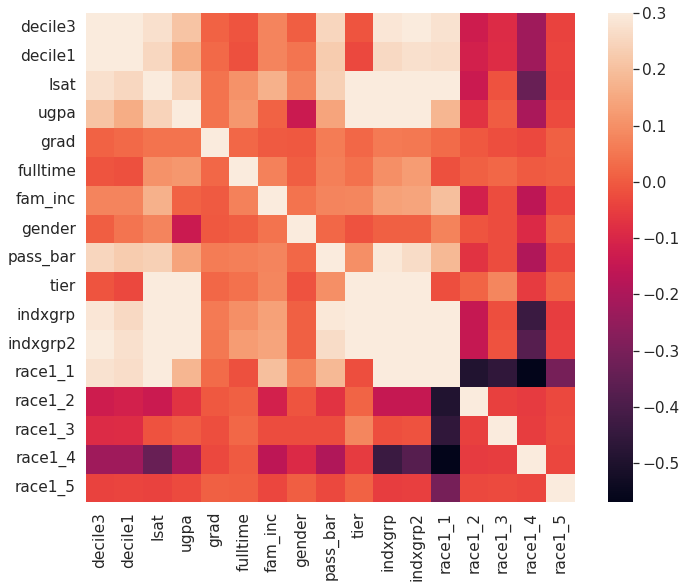

In [161]:
corrmat = df.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.3, square=True)

In [162]:
df.drop("pass_bar", axis=1).apply(lambda x: (x.corr(df['pass_bar']))).sort_values(ascending=False)


indxgrp     0.290859
indxgrp2    0.263613
decile3     0.251772
lsat        0.237747
decile1     0.228122
race1_1     0.187679
ugpa        0.143276
tier        0.099316
fam_inc     0.078080
fulltime    0.066542
grad        0.061763
gender      0.022393
race1_3    -0.023754
race1_5    -0.031092
race1_2    -0.071420
race1_4    -0.192717
dtype: float64

# Preprocessing

Now I'm going to split the sample into training and testing sets.

In [163]:
# Randomize the data
 
df = df.sample(frac=1).reset_index(drop=True)

df_train = df.iloc[:int(df.shape[0] * .8), :]
df_test = df.iloc[int(df.shape[0] * .8):, :]


I would normally transform the data here, but there are no skewness issues and no huge differences between the values of the features, so I'm just going to leave it. We've also already encoded out categorical data.

### PCA

Let's have a look at the data in a PCA space. 

In [164]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=3)

components = pca.fit_transform(df_train)

total_var = pca.explained_variance_ratio_.sum()*100

fig = px.scatter_3d(components, x=0, y=1, z=2, color=1, size = 1*np.ones(len(components)), opacity = 1,width = 800, height = 500)

In [165]:
fig.show()

Now we're going to split the data to create a validation set that we will use to pick a model or models to use.

In [166]:
y = df_train['pass_bar'].copy()
X = df_train.drop(['pass_bar'], axis = 1).copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, test_size=0.2)



# Model Selection and Grid Search

I'm going to look at the logistic regression, K nearest neighbors, support vector, random forrest, XG boost, LGBM, Cat Boost and naive bayes classifiers to see which works best on the data then run ones that work best through cross validation and ensemble their predcitions to get our final predictions.


In [167]:
# Classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(random_state=0, probability=True),
    "RandomForest": RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM": LGBMClassifier(random_state=0),
    "CatBoost": CatBoostClassifier(random_state=0, verbose=False),
    "NaiveBayes": GaussianNB()
}


In [168]:

# Grids for grid search
LR_grid = {'penalty': ['l1', 'l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto'],
            'probability': [True]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
           'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15]}

NB_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}


In [169]:
# Dictionary of all grids
grid = {
    "LogisticRegression": LR_grid,
    "KNN": KNN_grid,
    "SVC": SVC_grid,
    "RandomForest": RF_grid,
    "XGBoost": boosted_grid,
    "LGBM": boosted_grid,
    "CatBoost": boosted_grid,
    "NaiveBayes": NB_grid
}


In [170]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None, verbose = True)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model: LogisticRegression
Training time (mins): 0.11

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Model: KNN
Training time (mins): 0.34

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Model: SVC
Training time (mins): 78.98

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Model: RandomForest
Training time (mins): 1.24

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Model: XGBoost
Training time (mins): 2.99

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Model: LGBM
Training time (mins): 0.33

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Model: CatBoost
Training time (mins): 4.41

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Model: NaiveBayes
Training time (mins): 0.01



In [171]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.952301,0.11
1,KNN,0.952022,0.34
2,SVC,0.951743,78.98
3,RandomForest,0.952022,1.24
4,XGBoost,0.952022,2.99
5,LGBM,0.951464,0.33
6,CatBoost,0.952301,4.41
7,NaiveBayes,0.861646,0.01


It looks like we got very similar scores for everything but naive bayes. I've tried running the model with basically every combination of models (leaving out Naive Bayes) and it doesn't really have an effect on the results. I'm going to run it here with logistic regression, cat boost and K nearest neighbors.

In [172]:
# Show best parameters from grid search
clf_best_params


{'LogisticRegression': {'C': 1.25, 'max_iter': 50, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 1},
 'SVC': {'C': 1.5, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True},
 'RandomForest': {'max_depth': 10, 'n_estimators': 200},
 'XGBoost': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150},
 'LGBM': {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 50},
 'CatBoost': {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 50},
 'NaiveBayes': {'var_smoothing': 1e-10}}

In [173]:
best_classifiers = {
    "LogisticRegression": LogisticRegression(**clf_best_params["LogisticRegression"]),
    #"RandomForest": RandomForestClassifier(**clf_best_params["RandomForest"]),
    "CatBoost": CatBoostClassifier(**clf_best_params["CatBoost"]),
    #"XGBoost" : XGBClassifier(**clf_best_params["XGBoost"]),
    #"LGBM": LGBMClassifier(**clf_best_params["LGBM"]),
    "KNN": KNeighborsClassifier(**clf_best_params["KNN"]),
    #"SVC": SVC(**clf_best_params["SVC"]),
}

In [174]:
X_test = df_test.drop(['pass_bar'], axis = 1).copy()
y_test = df_test['pass_bar'].copy()

In [175]:
FOLDS = 10

preds = np.zeros(len(X_test))
ava = 0
for key, classifier in best_classifiers.items():
    start = time.time()

    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)

    score = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        
        # Train and score
        clf = classifier
        clf.fit(X_train, y_train)

        preds += clf.predict_proba(X_test)[:, 1] 
        score += clf.score(X_val, y_val)

    score = score / FOLDS

    stop = time.time()

    ava += np.round(100*score, 2)
    

    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score, 2),)
    print('Average training time (mins):', np.round((stop - start)/60, 2))



preds = preds / (len(best_classifiers)*FOLDS)


Model: LogisticRegression
Average validation accuracy: 94.92
Average training time (mins): 0.03
0:	learn: 0.5789080	total: 2.36ms	remaining: 116ms
1:	learn: 0.4944949	total: 4.17ms	remaining: 100ms
2:	learn: 0.4308432	total: 5.93ms	remaining: 92.9ms
3:	learn: 0.3794279	total: 8.03ms	remaining: 92.4ms
4:	learn: 0.3395715	total: 9.82ms	remaining: 88.4ms
5:	learn: 0.3068257	total: 11.5ms	remaining: 84.5ms
6:	learn: 0.2800949	total: 13.2ms	remaining: 81.1ms
7:	learn: 0.2584104	total: 15.2ms	remaining: 79.7ms
8:	learn: 0.2406953	total: 17.1ms	remaining: 78.1ms
9:	learn: 0.2259172	total: 19.2ms	remaining: 76.7ms
10:	learn: 0.2133294	total: 21.2ms	remaining: 75.3ms
11:	learn: 0.2030526	total: 23.3ms	remaining: 73.8ms
12:	learn: 0.1944446	total: 25.3ms	remaining: 72.1ms
13:	learn: 0.1874425	total: 27.5ms	remaining: 70.7ms
14:	learn: 0.1823277	total: 29.3ms	remaining: 68.3ms
15:	learn: 0.1768464	total: 31.4ms	remaining: 66.8ms
16:	learn: 0.1727018	total: 33.4ms	remaining: 64.9ms
17:	learn: 0.16

Now I have an ensembled result for the three models I used. Let's see how it looks.

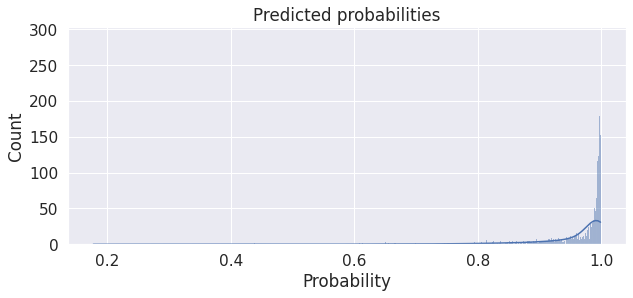

In [176]:
plt.figure(figsize=(10, 4));
sns.histplot(preds, binwidth=0.0005, kde=True);
plt.title('Predicted probabilities');
plt.xlabel('Probability');


In [177]:
# Proportion (in test set) we get from rounding
print(np.round(100*np.round(preds).sum()/len(preds),2))

99.13


Our model gives us an average probability of 99.24% for passing the bar.

In [178]:
preds_50=(preds>=.5).astype(int)

In [179]:
df_submit = pd.DataFrame({'per_pas': preds, 'preds_50': preds_50, 'pass_bar': y_test})


In [180]:
df_submit['correct'] = df_submit['preds_50'] == df_submit['pass_bar']


In [181]:
def confusion_matrix(df, threshold):
    df = df.copy()
    df['preds'] = np.where(df['per_pas'] > threshold, 1, 0).astype(int)
    df['correct'] = df['preds'] == df['pass_bar']
    return pd.crosstab(df['pass_bar'], df['preds'], margins=True)

In [182]:
confusion_matrix(df_submit, .5)

preds,0,1,All
pass_bar,,,
0,22,227,249
1,17,4216,4233
All,39,4443,4482


Note: We have almost 20 times as many false positives as false negatives.

In [183]:
acc = np.round(100*df_submit['pass_bar'].sum()/df_submit.shape[0],2)
pred = np.round(100*df_submit['correct'].sum()/df_submit.shape[0],2)



print('Percentage correct: ' + str(pred),'%')
print('Percentage correct if we always predict pass (baseline): ' + str(acc), '%')
print('Percent improvement over baseline: ' + str(np.round(100*(acc-pred)/(1-acc),2)), '%') 


Percentage correct: 94.56 %
Percentage correct if we always predict pass (baseline): 94.44 %
Percent improvement over baseline: 0.13 %


In [184]:

median_fail = str(np.round(100*df_submit[df_submit['pass_bar'] == 0].sort_values(
    by=['per_pas'], ascending=False).iloc[int((df_submit[df_submit['pass_bar'] == 0].shape[0]/2)),:]['per_pas'],2))


print("Median predicted probability of passing for students who didn't pass the bar: " + median_fail, '%')

Median predicted probability of passing for students who didn't pass the bar: 84.79 %


# Conclusion

I really wasn't able to find a model that had any predictive power on this dataset with this target variable. After fiddling with hyperparameters for over a day I have found no model or combination of models that gives more than a few tenths of a percentage point improvement over an "always chose pass" strategy. Part of me thinks this makes sense since there are very few clear "this student will fail" cases and a lot of cases where students have relatively high predicted probabilities of passing, but still wind up failing. In fact, looking at the line above it seems like over half of the people who flunked the bar had over an 85% chance of passing.

I think I did some good EDA here, but I wasn't able to come up with a model that had any significant predictive power. That may have been my inability to put one together or this data may just be very resistant to accurate predictions.

Thanks for reading my work. If you have any comments or suggestions, I would love to hear them.

Best,

Eric